# 示範指令使用

### 用指令算 3gram 

In [1]:
!egrep -o '([^ ]+ ){2}[^ ]+' VOA.txt | tr 'A-Z' 'a-z' | \
sort -r  | uniq -c | awk '{if ($1 > 1) printf "%s %s %s\t%s\n",$2,$3,$4,$1 }' | \
head -20

zurich protested the	2
zuhir al-naimi ,	3
zuhayr talib abd	4
zubaidi does not	2
zoran zivkovic said	2
zoran zivkovic ,	2
zoran djindjic has	2
zoran djindjic .	10
zora neale hurston	8
zones over northern	2
zone that divides	2
zone monday attacked	2
zone in the	3
zone between north	3
zone along the	2
zone about 370	2
zone , where	2
zoellick formalized the	2
zivkovic possible candidacy	2
zimbabwean president robert	2
awk: write error on stdout
 input record number 6909, file 
 source line number 1
uniq: write error: Broken pipe


### 縮小檔案基本方法
- `wc -l file` 算行數
- `head -# file > new_file`  取前 # 行
- `head -c #m > new_file` 取前 #mb 資料

-----

# Lab3開始

# word tokenize
- 使用 nltk, pattern 或 textblob 做 word tokenize。這邊統一使用 nltk 的 wordpunct_tokenize 切字。
- 資料取原始檔案的前 50000 行

# 計算 skip bigram 

- $p_j^i$ 
- ngram 任何位置不包含符號
- skip bigram 不包含 stop words 與數字

In [1]:
from __future__ import division

k0 = 1
k1 = 1
U0 = 10
max_distance = 5

In [2]:
# 示範 code ，修改下列 code 達到目的
# 可跳過 ngram ，直接計算 skip bigram
from nltk.tokenize import  wordpunct_tokenize 
from nltk.corpus import stopwords 
eng_stopwords = set(stopwords.words('english'))
eng_symbols = '{}"\'()[].,:;+!?-*/&|<>=~$'
def ngram_is_valid(ngram):
    first, last = ngram[0], ngram[-1]
    if first in eng_stopwords or last in eng_stopwords: return False
    if any( num in first or num in last for num in '0123456789'): return False
    if any( eng_symbol in word for word in ngram for eng_symbol in eng_symbols): return False
    return True

from collections import defaultdict, Counter
def to_ngrams( unigrams, length):
    return zip(*[unigrams[i:] for i in range(length)])  

from nltk.tokenize import  wordpunct_tokenize 
ngram_counts = defaultdict(Counter)
with open('citeseerx_descriptions_sents.txt.50000') as text_file:
    for index,line in enumerate(text_file): 
        words = wordpunct_tokenize(line)
        for n in range(2, max_distance + 2):
            ngram_counts[n].update(filter(ngram_is_valid, to_ngrams(words, n)))

In [15]:
position = []

with open('citeseerx_descriptions_sents.txt.50000') as text_file:
    for index,line in enumerate(text_file): 
        words = wordpunct_tokenize(line)
        position += [ g for d in range(1, 6) for g in zip(words, words[d:], [d]*len(words)) if g[0] not in eng_stopwords 
                     and g[0].isalpha() and g[1] not in eng_stopwords and g[1].isalpha()]
        position += [ g for d in range(1, 6) for g in zip(words[d:], words, [-d]*len(words)) if g[0] not in eng_stopwords 
                     and g[0].isalpha() and g[1] not in eng_stopwords and g[1].isalpha()]

In [16]:
print position[len(position)-10:]

[('available', 'phosphorus', -3), ('reduces', 'raises', -4), ('fixed', 'iron', -4), ('available', 'fixed', -4), ('reduces', 'Flooding', -5), ('iron', 'raises', -5), ('allowing', 'pH', -5), ('fixed', 'reduces', -5), ('phosphorus', 'iron', -5), ('become', 'allowing', -5)]


In [17]:
from collections import defaultdict
skip_bigram_info = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
for pos in position:
    first_ele = pos[0]
    second_ele = pos[1]
    relation = pos[2]
    skip_bigram_info[first_ele][second_ele][relation] += 1

In [18]:
print skip_bigram_info["play"]["role"]

defaultdict(<function <lambda> at 0x0000000051F8F5F8>, {2: 8, 3: 51, 4: 5, 5: 1, -5: 1, -4: 2, -2: 2})


### 階段檢查資料


In [19]:
print skip_bigram_info['role'].items()[:10]

[('limited', defaultdict(<function <lambda> at 0x000000004EEE03C8>, {3: 1})), ('concept', defaultdict(<function <lambda> at 0x000000004EEE5128>, {1: 1, -5: 1, 4: 1, -2: 1})), ('semantic', defaultdict(<function <lambda> at 0x00000000572A8588>, {2: 1, -1: 1})), ('consider', defaultdict(<function <lambda> at 0x0000000071511F98>, {5: 1})), ('graphics', defaultdict(<function <lambda> at 0x0000000085C024A8>, {3: 1})), ('focus', defaultdict(<function <lambda> at 0x000000005F67A278>, {-4: 1, -5: 1, 4: 1})), ('Does', defaultdict(<function <lambda> at 0x0000000052074198>, {-2: 1})), ('computation', defaultdict(<function <lambda> at 0x00000000528ED748>, {-4: 1, 2: 1, 4: 1})), ('reasoning', defaultdict(<function <lambda> at 0x00000000739B7CF8>, {-4: 1})), ('issues', defaultdict(<function <lambda> at 0x000000005DD7AC88>, {3: 1, -5: 1}))]


# 計算 skip bigram 的各種統計資訊 
$freq,\ \bar{f},\ \sigma,\ u_i,\ \bar{p_i}$

In [20]:
import numpy as np
np.std([4,8,16,92,25,2,142,345,32,3])

102.41821127123829

In [23]:
def freq(skip_bigram_info,first_word, second_word):
    return sum(skip_bigram_info[first_word][second_word].values())

def avg_freq(skip_bigram_info,first_word):
    value_list = []
    for item in skip_bigram_info[first_word].values():
        value_list += item.values()
    return float(sum(value_list))/ len(skip_bigram_info[first_word])

def collocation_avg_freq(skip_bigram_info,first_word, second_word):
    return float(len(skip_bigram_info[first_word][second_word].items()))/freq(skip_bigram_info,first_word, second_word)

def dev(skip_bigram_info,first_word):
    value_list = []
    for item in skip_bigram_info[first_word].values():
        value_list += item.values()
    return np.std(value_list)

def spread(skip_bigram_info,first_word, second_word):
    mue = []
    p_bar = sum(skip_bigram_info[first_word][second_word].values()) / 10
    for pi in skip_bigram_info[first_word][second_word].values():
        mue.append((pi - p_bar)**2)
    return sum(mue)/10
    
def strength(skip_bigram_info,first_word, second_word):
    if dev(skip_bigram_info,first_word) <= 0:
        return 0
    else:
        return float(freq(skip_bigram_info,first_word, second_word) - avg_freq(skip_bigram_info,first_word))/dev(skip_bigram_info,first_word)
    
def peak_detect(skip_bigram_info,first_word, second_word):
    good_distance = []
    p_bar = sum(skip_bigram_info[first_word][second_word].values()) / 10
    for distance, count in skip_bigram_info[first_word][second_word].items():
        if count >= p_bar + np.sqrt(strength(skip_bigram_info,first_word,second_word)):
            good_distance.append(distance)
    return good_distance

def peak(skip_bigram_info,first_word,second_word):
    p_bar = sum(skip_bigram_info[first_word][second_word].values()) / 10
    return p_bar + np.sqrt(strength(skip_bigram_info,first_word,second_word))

print "good distance:",peak_detect(skip_bigram_info,"years","ago")

 good distance: [1]


In [25]:
skip_bigram_info["work"]["future"]

defaultdict(<function __main__.<lambda>>,
            {-4: 1, -3: 2, -2: 2, -1: 22, 2: 1, 5: 1})

In [27]:
peak_detect(skip_bigram_info,"play","important")

[2]

### 階段檢查資料
- $\bar{f}$ : `avg_freq`
- $\sigma$ : `dev`
- $u_i$ : `spread`
- $freq$ : `freq`


In [28]:
base_word = "subsequentlub"
collocation = "Research"
print skip_bigram_info[base_word][collocation]
print "strength:", strength(skip_bigram_info,base_word,collocation)
print "spread:", spread(skip_bigram_info,base_word,collocation)
print "peak:", peak(skip_bigram_info,base_word,collocation)
print peak_detect(skip_bigram_info,base_word,collocation)
for i in peak_detect(skip_bigram_info,base_word,collocation):
    print skip_bigram_info[base_word][collocation][i]

defaultdict(<function <lambda> at 0x000000007DF6ADD8>, {3: 1})
strength: 0
spread: 0.081
peak: 0.1
[3]
1


# 依據 Smadja’s 三個規則篩選 skip bigrams

$$\begin{cases} 
strength = \frac{freq - \bar{f}}{\sigma} \ge k_0 & (C_1)\\
spread \ge u_0 & (C_2) \\
p_j^i \ge \bar{p_i} + (k_1 \times \sqrt{u_i}) & (C_3) 
\end{cases}$$

In [31]:
def Smadja(skip_bigram_info,first_word,second_word):
    if strength(skip_bigram_info,first_word,second_word)>=1 and spread(skip_bigram_info,first_word,second_word) >= 10:
        print "good pair"
        print "good distance:",peak_detect(skip_bigram_info,first_word,second_word)
    else :
        print "try other combination"
Smadja(skip_bigram_info,"subsequentlub","Research")

try other combination


In [32]:
def Smadja_filter(skip_bigram_info,first_word,second_word):
    if strength(skip_bigram_info,first_word,second_word)>=1 and spread(skip_bigram_info,first_word,second_word) >= 10:
        return True
    else :
        return False
Smadja_filter(skip_bigram_info,"subsequentlub","Research")

False

## 使用 pandas 畫出 play role 的各距離數量 

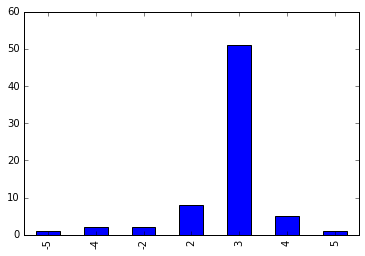

In [33]:
import pandas 
%matplotlib inline
play_role_distances_count = pandas.Series(skip_bigram_info['play']['role'].values(), index= skip_bigram_info['play']['role'].keys()).sort_index()
play_role_distances_count.plot(kind='bar')

## 使用 pandas Dataframe 整理與顯示資料

In [34]:
#create cc = [('base word', 'collocate', 'distance', 'strength', 'spread', 'peak', 'p').......]
cc = []
for base_word in skip_bigram_info:
    for collocation in skip_bigram_info[base_word]:
        if Smadja_filter(skip_bigram_info,base_word,collocation):
            for dis in peak_detect(skip_bigram_info,base_word,collocation):
                cc.append((base_word,collocation,dis,strength(skip_bigram_info,base_word,collocation),
                           spread(skip_bigram_info,base_word,collocation),peak(skip_bigram_info,base_word,collocation),
                           skip_bigram_info[base_word][collocation][dis]))

In [35]:
# cc = [('base word', 'collocate', 'distance', 'strength', 'spread', 'peak', 'p').......]
import pandas
collocations_df = pandas.DataFrame(cc,
                                   columns = ['base word', 'collocate', 'distance', 'strength', 'spread', 'peak', 'p'])
collocations_df = collocations_df.set_index(['base word', 'collocate', 'distance']).sort_index()

### 列出 collocation Dataframe

In [36]:
collocations_df

strength   spread       peak    p
base word collocate distance                                    
A         B          2         8.229903   12.694   5.168781   13
          D          2         4.624230   11.272   3.550402   12
          algorithm  2        14.239358   13.384   7.573507   11
                     4        14.239358   13.384   7.573507   10
                     5        14.239358   13.384   7.573507    8
          amp       -4        18.646292   15.887   9.218135   12
                     2        18.646292   15.887   9.218135   14
          approach   2        25.056378   78.700  11.505635   33
                     4        25.056378   78.700  11.505635   15
          based      3        22.652596   38.685  10.659474   22
                     4        22.652596   38.685  10.659474   14
                     5        22.652596   38.685  10.659474   12
          challenge  2         3.822970   11.664   3.155242   12
          common     1         7.428643   32.162   4.825554   20
          detailed   1         4.624230   11.268   3.550402   12
          feature    2         9.031164   14.525   5.505190   14
          general    1         5.826121   12.987   4.113736   13
          key        1         9.832425   38.165   5.835670   22
          major      1         6.627382   29.241   4.474370   19
          method     1        21.450705   43.760  10.231491   12
                     2        21.450705   43.760  10.231491   25
          model      1        33.870245   65.165  14.519815   18
                     2        33.870245   65.165  14.519815   29
                     3        33.870245   65.165  14.519815   21
          new        1        33.469615  506.456  14.385293   78
          novel      1        18.245662  179.528   9.071494   47
          number     1        16.242510   85.667   8.330200   33
                     2        16.242510   85.667   8.330200    9
          presented  4         9.031164   12.075   5.505190   11
                     5         9.031164   12.075   5.505190    9
...                                 ...      ...        ...  ...
work      done       1         7.133896   11.384   5.270935    8
                     2         7.133896   11.384   5.270935    6
                     3         7.133896   11.384   5.270935   11
          earlier   -1         4.108796   15.448   3.627017   14
          future    -1         8.041426   37.726   5.735741   22
          main      -4         3.503776   11.268   3.271838   12
          paper     -4        14.394136   27.500   8.793961   15
                    -3        14.394136   27.500   8.793961   17
          present   -2         8.948956   10.088   6.191481    7
                    -1         8.948956   10.088   6.191481   11
                     3         8.948956   10.088   6.191481    7
          previous  -1        24.074457  434.340  13.106573   73
          progress   2         4.713816   11.016   3.971132   12
                     4         4.713816   11.016   3.971132    4
          recent    -1         7.436406   54.578   5.426977   26
works     previous  -1        15.132693   13.048   5.490076   13
world     data       1         4.638146   10.740   3.953636   12
          real      -2        47.319196  939.592  23.478895  100
                    -1        47.319196  939.592  23.478895   66
worst     case       1        19.846472   68.547   9.154938   22
                     2        19.846472   68.547   9.154938   24
would     like       1        23.260480   28.107   7.122912   19
www       http      -2         9.685527   38.978   5.412158   22
x         n          2        14.656153   11.023   6.528336   13
years     In        -2        11.852753   73.400   7.442783   31
          last      -2        11.852753   63.000   7.442783   28
                    -1        11.852753   63.000   7.442783   10
          many      -1         5.017969   17.492   4.040082   15
          past      -2        12.474097   96.376   7.731869   35
 

### 依據 strength 排序 collocation

In [37]:
collocations_df.sort(columns = 'strength', ascending=False)[:10]

c:\python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


strength      spread        peak     p
base word collocate distance                                         
system    The       -4        95.607106    1211.012   37.177889    43
                    -1        95.607106    1211.012   37.177889   115
                    -2        95.607106    1211.012   37.177889    77
amp       quot      -4        91.319528  405687.694  321.856125   548
                     2        91.319528  405687.694  321.856125  2244
quot      amp       -2        90.980796  405687.694  321.838385  2244
                     4        90.980796  405687.694  321.838385   548
time      real      -2        90.777087   12264.992   57.327701   380
                    -1        90.777087   12264.992   57.327701    74
model     The       -2        88.655304     971.965   35.715695    68

### collocation Dataframe 的各欄位統計數據

In [110]:
collocations_df.describe()

,strength,spread,peak,p
count,6110.000000,6110.000000,6110.000000,6110.000000
mean,16.010012,811.156364,10.268738,27.732897
std,12.194707,15853.334727,11.617230,83.771505
min,1.004132,10.000000,6.187968,4.000000
25%,7.292977,15.187000,7.187968,12.000000
50%,13.505705,26.244000,8.387968,16.000000
75%,21.501500,68.000000,10.487968,25.000000
max,95.607106,509728.703000,317.287968,2441.000000


### role 的相關 collocations

In [111]:
collocations_df.loc['role']

,,strength,spread,peak,p
collocate,distance,,,,
The,-1,7.711743,17.324,6.887968,15
important,-1,17.967880,122.612,9.187968,39
play,-3,30.453612,206.300,11.987968,51
plays,-3,11.279095,31.094,7.687968,20


### strength 的數據分佈

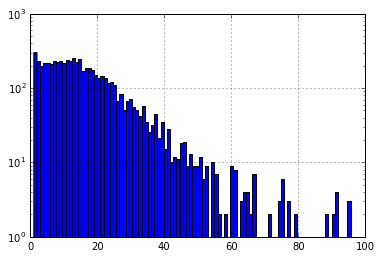

In [112]:
collocations_df.strength.hist(bins=100, log=True)

### 複雜篩選處理示範

In [115]:
collocations_df[ collocations_df.index.map(lambda x: x[2] == 1) & (collocations_df.spread > 500)  & (collocations_df.peak > 100)
                ].sort(columns='strength', ascending=False)[:20]

c:\python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,,,strength,spread,peak,p
base word,collocate,distance,,,,
This,paper,1,63.322337,323104.24,202.187968,1953


# BONUS!!!
使用 `citeseerx100000.tag.txt` 找出 VN 關係的 collocations

In [3]:
#create VN collocations dictionary
position_bonus = []

with open('citeseerx100000.tag.txt') as bonus_file:
    for index,line in enumerate(bonus_file):
        words = line.split()
        #positive position V -> N
        position_bonus += [ (g[0].split("/")[0],g[1].split("/")[0],g[2]) for d in range(1, 6) for g in zip(words, words[d:], [d]*len(words)) 
                     if  "/V" in g[0] and  "/N" in g[1] and g[0].split("/")[0].isalpha() and g[1].split("/")[0].isalpha()]
        #negative position N->V
        position_bonus += [ (g[0].split("/")[0],g[1].split("/")[0],g[2]) for d in range(1, 6) for g in zip(words[d:], words, [-d]*len(words)) 
                     if  "/N" in g[0] and  "/V" in g[1] and g[0].split("/")[0].isalpha() and g[1].split("/")[0].isalpha()]

#create triple-nested default dictionary       
VN_skip_bigram_info = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

for pos in position_bonus:
    first_ele = pos[0]
    second_ele = pos[1]
    relation = pos[2]
    VN_skip_bigram_info[first_ele][second_ele][relation] += 1

In [7]:
position_bonus[:10]

[('include', 'class', 2),
 ('partition', 'set', 3),
 ('be', 'set', 4),
 ('include', 'system', 4),
 ('partition', 'disjoint', 5),
 ('call', 'class', 5),
 ('class', 'include', -2),
 ('set', 'partition', -3),
 ('set', 'be', -4),
 ('system', 'include', -4)]

In [9]:
dict(VN_skip_bigram_info.items()[0:2])

{'spidere': defaultdict(<function __main__.<lambda>>,
             {'efficiency': defaultdict(<function __main__.<lambda>>, {1: 1}),
              'search': defaultdict(<function __main__.<lambda>>, {5: 1})}),
 'subsequentlub': defaultdict(<function __main__.<lambda>>,
             {'otherwisewoul': defaultdict(<function __main__.<lambda>>,
                          {-3: 1})})}

In [38]:
VN_skip_bigram_info["play"]["role"]

defaultdict(<function __main__.<lambda>>, {1: 2, 2: 29, 3: 161, 4: 12, 5: 4})

In [40]:
VN_cc = []
for base_word in VN_skip_bigram_info:
    for collocation in VN_skip_bigram_info[base_word]:
        if Smadja_filter(VN_skip_bigram_info,base_word,collocation):
            for dis in peak_detect(VN_skip_bigram_info,base_word,collocation):
                VN_cc.append((base_word,collocation,dis,strength(VN_skip_bigram_info,base_word,collocation),
                           spread(VN_skip_bigram_info,base_word,collocation),peak(VN_skip_bigram_info,base_word,collocation),
                           VN_skip_bigram_info[base_word][collocation][dis]))
                
VN_collocations_df = pandas.DataFrame(VN_cc,
                                   columns = ['base word', 'collocate', 'distance', 'strength', 'spread', 'peak', 'p'])
VN_collocations_df = VN_collocations_df.set_index(['base word', 'collocate', 'distance']).sort_index()

In [41]:
VN_collocations_df

strength   spread       peak   p
base word collocate distance                                   
C         be        -5        18.448228   11.365   6.995140   7
                    -3        18.448228   11.365   6.995140  12
Give      set        2        18.350776   10.568   6.083781  10
                     3        18.350776   10.568   6.083781   8
Internet  be        -5        24.976000   80.365  11.297599  23
                    -4        24.976000   80.365  11.297599  28
          connect   -3         4.002856   11.664   3.200714  12
Java      be        -5        20.094184   28.600   9.482654  15
                    -4        20.094184   28.600   9.482654  16
                    -3        20.094184   28.600   9.482654  13
Markov    be        -5        12.779471   16.165   6.274839  14
                    -4        12.779471   16.165   6.274839   8
N         be        -3        14.401763   14.636   6.094965  14
O         be        -3        20.443693   80.085  12.421470  18
                    -1        20.443693   80.085  12.421470  34
          require   -2         5.001338   18.688   4.436367   7
                    -1         5.001338   18.688   4.436367  15
QoS       be        -5        14.049188   11.165   6.048225  11
                    -4        14.049188   11.165   6.048225   8
TCP       be        -5        19.308153   19.244   7.294104  14
                    -4        19.308153   19.244   7.294104  11
Use       model      2        28.373594   39.144   9.926687  20
                     3        28.373594   39.144   9.926687  17
          technique  2        11.688760   12.800   5.418883  13
Web       be        -5        25.961289   48.325   9.595222  17
                    -4        25.961289   48.325   9.595222  22
XML       be        -5        23.050984   33.085   8.901144   9
                    -4        23.050984   33.085   8.901144  20
                    -3        23.050984   33.085   8.901144  10
ability   be        -4        17.717359  110.016  11.009199  18
...                                 ...      ...        ...  ..
word      be        -5        31.561437   49.685  12.517957  21
                    -4        31.561437   49.685  12.517957  21
                    -3        31.561437   49.685  12.517957  15
          use       -3        13.067330   11.100   6.614876   7
                    -2        13.067330   11.100   6.614876  12
work      be        -5        44.362420  188.140  18.860512  43
                    -4        44.362420  188.140  18.860512  39
                    -3        44.362420  188.140  18.860512  22
          describe  -3        14.669645   30.540   8.030097  11
                    -2        14.669645   30.540   8.030097  20
          extend    -3        12.813846   41.996   7.279643  10
                    -2        12.813846   41.996   7.279643  23
          have      -5        12.813846   18.965   7.279643  11
                    -4        12.813846   18.965   7.279643  10
                    -3        12.813846   18.965   7.279643  13
          present   -3        16.525443   26.165   8.765150  11
                    -2        16.525443   26.165   8.765150  16
                    -1        16.525443   26.165   8.765150  14
          use       -3         6.504132   10.600   4.550320  12
world     be        -5        19.692323   19.304   7.837603  13
                    -4        19.692323   19.304   7.837603  13
          develop   -1         9.286179   12.987   4.747323  13
write     language   4        23.127613   13.675   7.309118  13
year      be        -5        16.887058   75.216  10.909387  23
                    -4        16.887058   75.216  10.909387  27
                    -3        16.887058   75.216  10.909387  15
          have      -5        10.684769   63.288   7.668757  28
                    -4        10.684769   63.288   7.668757  13
yield     result     2        26.246368   27.760   8.723121  17
                     3        26.246368   27.760   8.723121  13

In [42]:
VN_collocations_df.sort(columns = 'strength', ascending=False)[:10]

c:\python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


strength    spread       peak    p
base word collocate distance                                     
model     be        -4        60.013624  4710.365  57.046846  144
                    -3        60.013624  4710.365  57.046846   90
                    -5        60.013624  4710.365  57.046846  233
set       be        -5        59.845331  1640.940  41.535976  113
                    -2        59.845331  1640.940  41.535976   54
                    -4        59.845331  1640.940  41.535976  129
process   be        -5        58.420159   966.600  34.643308  111
                    -4        58.420159   966.600  34.643308   72
                    -3        58.420159   966.600  34.643308   48
                    -2        58.420159   966.600  34.643308   39

In [46]:
VN_collocations_df[ VN_collocations_df.index.map(lambda x: x[2] == 1) & (VN_collocations_df.spread > 50)  & (VN_collocations_df.peak > 10)
                ].sort(columns='strength', ascending=False)[:20]

c:\python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


strength    spread       peak    p
base word  collocate   distance                                     
propose    method      1         57.923977  2840.440  50.810780  202
allow      user        1         53.463107   499.685  21.211847   60
improve    performance 1         52.578702  1844.900  36.251117   57
make       use         1         51.036003  2022.965  29.843949  161
propose    algorithm   1         44.796480   967.725  40.193017  123
           approach    1         41.954444  1219.060  37.877225  127
distribute system      1         41.460237  1306.325  30.938962  121
provide    information 1         37.114306   261.285  19.992151   21
present    result      1         32.201750  1447.685  31.774659   44
report     result      1         29.580648   101.885  12.338809   13
increase   number      1         29.477250    83.140  11.629296   31
have       application 1         28.667178    81.500  16.354174   20
provide    support     1         28.581186   192.240  16.146137   29
exist      system      1         27.368619    69.560  12.831503   32
           algorithm   1         27.368619    60.160  12.831503   27
develop    method      1         27.210395    80.965  13.916358   14
be         part        1         25.971164   816.885  35.196191   70
embed      system      1         25.285571   482.540  15.228476   79
propose    model       1         25.172901   227.300  24.017260   35
exist      approach    1         24.383387   139.640  11.737954   43